In [1]:
from lib.utils import *
from lib.ekyn import *
from torch import nn
from torch.nn.functional import relu
import torch
import os
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from lib.models import Gandalf

from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [4]:
from sage.utils import *

In [5]:
FOLD = 12

folds = get_leave_one_out_cv_ids_for_ekyn()
train_ids,test_ids = folds[FOLD]

['E2-1', 'F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'C4-0', 'F5-1', 'E4-1'] ['A1-0']
testloader: 270 batches
0.9171643742862351


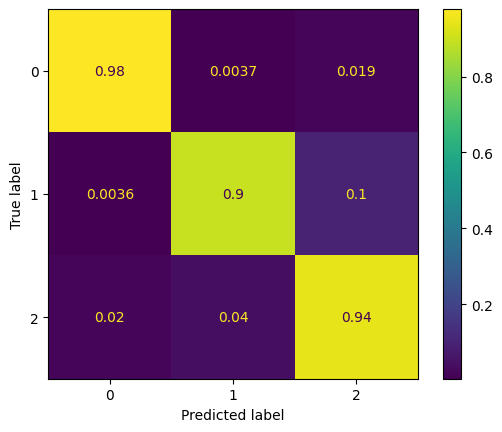

In [7]:
print(train_ids,test_ids)
X,y = load_eeg_label_pair(id=test_ids[0],condition='PF',zero_pad=False)
testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
print(f'testloader: {len(testloader)} batches')

model = Gandalf()
model.load_state_dict(torch.load(f=f'{GANDALFS_PATH}/gandalf_{FOLD}/best_model.pt',map_location='cpu',weights_only=False))
model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
loss,y_true,y_pred = evaluate(testloader,model,criterion,'cuda')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
report = classification_report(y_true,y_pred,output_dict=True)
print(report['macro avg']['f1-score'])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

folds = get_leave_one_out_cv_ids_for_ekyn()
criterion = torch.nn.CrossEntropyLoss()
reports = []

for FOLD,(train_ids,test_ids) in tqdm(enumerate(folds)):
    model = Gandalf()
    model.load_state_dict(torch.load(f=f'{GANDALFS_PATH}/gandalf_{FOLD}/best_model.pt',map_location='cpu',weights_only=False))
    model.to(DEVICE)
    for condition in ['Vehicle','PF']:
        X,y = load_eeg_label_pair(id=test_ids[0],condition=condition,zero_pad=False)
        testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
        loss,y_true,y_pred = evaluate(testloader,model,criterion,'cuda')
        report = classification_report(y_true,y_pred,output_dict=True)
        reports.append(report)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Construct the DataFrame in wide format first
wide_df = pd.DataFrame({
    'precision': [report['macro avg']['precision'] for report in reports],
    'recall': [report['macro avg']['recall'] for report in reports],
    'f1-score': [report['macro avg']['f1-score'] for report in reports]
})

wide_df = wide_df.drop([11,28])

# Use melt to convert the wide DataFrame into long format
long_df = wide_df.melt(var_name='metric', value_name='value')

# Create the boxplot using the long format DataFrame
plt.figure(figsize=(8, 6))
sns.boxplot(x='metric', y='value', data=long_df)
plt.title('Boxplot of Macro Avg Precision, Recall, and F1-Score')
plt.show()